<a href="https://colab.research.google.com/github/leeds1219/DL_and_AI_Notes_and_Projects/blob/main/Generative_Adversarial_Networks_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 20. Generative Adversarial Networks

In [ ]:
# 20.1 GAN uses a two-sample test

# Generator with Noise(z) input creates a Fake G(z)
# Discriminator with input(x)
# classify if it is real or fake
# when the fake G(z) pass the classifier an image(speech etc) is generated

# The discriminator is a binary classifier to distinguish if the input(x) is real
# or fake (from generator) and gives an scalr prediction o(a real number) for input using
# a fully connected layer with hidden size 1 and then applies sigmoid function
# to obtain the predicted probability D(x) = 1/(1+exp(-o)).
# Assume the label y for the true data is 1 and fake is 0.

# We train the discriminator to minimize the cross-entropy loss
# min(D){-ylogD(x)-(1-y)log(1-D(x))}

# For the Generator it draws some parameter z from z ~ N(0,1) z is called latent variable
# it applies a function to generate x` = G(z).
# The goal of the gnerator is to fool the discriminator to classify x` = G(z) as true
# Thus we want D(G(z)) ~ 1 for given discriminator D we update the parameters of G to
# maximize cross-entropy loss when y = 0(fake)
# max(G){-(1-y)log(1-D(G(z)))} = max(G){-log(1-D(G(z)))}

# If D(x`) ~ 1 so loss is near 0.
# So we minimize the following loss
# min(G){-ylog(D(G(z)))} = min(G){-log(D(G(z)))}

# which is just feeding x` = G(z) into the discriminator but giving label y = 0(true)
# In other words, D and G are playing a "minimax" game!!!
# min(D)max(G){-E_x~DatalogD(x)-E_z~Noiselog(1-D(G(z)))}

#  We will illustrate what happens if we use GANs to build
# the world’s most inefficient estimator of parameters for a Gaussian

In [2]:
# d2l in colab
!pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 95.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:


In [3]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
# 20.1.1. Generate Some "Real" Data

X = torch.normal(0.0, 1, (1000,2))
A = torch.tensor([[1, 2], [-0.1, 0.5]])
b = torch.tensor([1, 2])
data = torch.matmul(X, A) + b

# This should be a Gaussian shifted in some arbitary way with mean b
# and covariance matrix A^TA.

The covariance matrix is
tensor([[1.0100, 1.9500],
        [1.9500, 4.2500]])


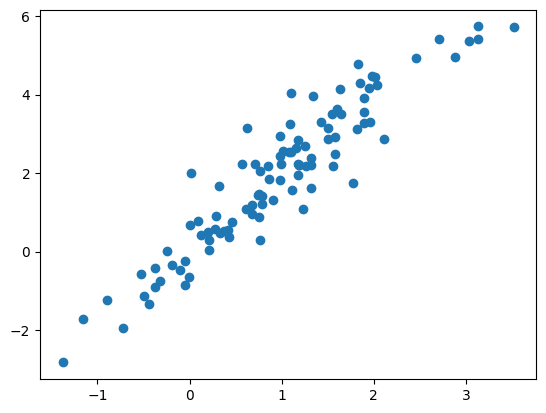

In [7]:
d2l.set_figsize
d2l.plt.scatter(data[:100, (0)].detach().numpy(), data[:100,(1)].detach().numpy());
print(f'The covariance matrix is\n{torch.matmul(A.T, A)}')

In [8]:
batch_size = 8
data_iter = d2l.load_array((data,), batch_size)

In [10]:
# 20.1.2. Generator

# A sequential network with a single linear layer
# nn.Sequential creates an container
# nn.Linear(2,2) defines a linear layer Linear(# of input features, # of output features)
# which is a fully connected layer
# this is a simple feedforward nn
net_G = nn.Sequential(nn.Linear(2,2))

In [11]:
# 20.1.3. Discriminator

# MLP with 3 layers and 2 Tanh activation function to introduce non-linearity
# third layer flattens the output to 1 dimension, for binary classification tasks
net_D = nn.Sequential(
    nn.Linear(2, 5), nn.Tanh(),
    nn.Linear(5, 3), nn.Tanh(),
    nn.Linear(3, 1)
)

In [12]:
# 20.1.4. Training

# Discriminator update
def update_D(X, Z, net_D, net_G, loss, trainer_D) :
# Check input tensor X shape specifically retrieves
# the size (length) of the first dimension of the array or tensor.
# The first dimension is often associated with the number of samples or elements in a dataset,
# and it's typically used when dealing with batch processing in deep learning.
  batch_size = X.shape[0]
# .device attribute is used to determine or set the device (usually a CPU or a GPU)
# on which a PyTorch tensor or model resides.
# It allows you to manage the placement of your data and models for computations.
# ones and zeros are labels for real and fake data
  ones = torch.ones((batch_size,), device = X.device)
  zeros = torch.zeros((batch_size,), device = X.device)
# It clears the gradients of discriminator's parameters to prepare for backpropagation
  trainer_D.zero_grad()
# computes the discriminator's output for real X
  real_Y = net_D(X)
# generates fake data using net_G with noise Z
  fake_X = net_G(Z)
# Do not need to compute gradient for `net_G`, detach it from computing
# .detach() is used to prevent gradients from being propagated back to the generator
# during the computation of fake_Y.
# This is a common practice in GAN training where you only want to update the discriminator's parameters
# and not the generator's parameters during the discriminator update.
# this computes the discriminator's output for the generated fake data(above)
  fake_Y = net_D(fake_X.detach())
# Discriminator loss one for real one for fake
# binary cross-entropy loss
# the loss is assumed to be a binary cross-entropy loss function
  loss_D = (loss(real_Y, ones.reshape(real_Y.shape)))+loss(fake_Y, zeros.reshape(fake_Y.shape))/2
# computes the gradients of discriminator's parameters with respect to the loss
  loss_D.backward()
# updates discriminator's parameters
# trainer_D is an instance of torch.optim.Optimizer
  trainer_D.step()
  return loss_D
# discriminator is updated based on the real and fake data to better distinguish between them.

In [13]:
# The Generator update

# similarly updated reusing the cross-entropy loss but changing the label of fake
# data from 0 to 1
def update_G(Z, net_D, net_G, loss, trainer_G) :
  batch_size = Z.shape[0]
  ones = torch.ones((batch_size,), device = Z.device)
  trainer_G.zero_grad()

  fake_X = net_G(Z)

  fake_Y = net_D(fake_X)
  loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
  loss_G.backward()
  trainer_G.step()
  return loss_G

In [14]:
# Both D and G performs a binary logistic regression with ce-loss
# We use Adam to smooth the training process
# in each iteration we fist update D and G
# visualize both losses and generated examples.

def train(net_d, netG, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):

  loss = nn.BCEWithLogitsLoss(reduction = 'sum')

  for w in net_D.parameters():
    nn.init.normal_(w,0,0.02)
  for w in net_G.parameters():
    nn.init.normal_(w,0,0.02)

  trainer_D = torch.optim.Adam(net_D.parameters(), lr = lr_D)
  trainer_G = torch.optim.Adam(net_G.parameters(), lr = lr_G)

  animator = d2l.Animator(xlabel = 'epoch', ylabel = 'loss', xlim = [1, num_epochs], nrows = 2,
                          figsize = (5, 5), legend = ['discriminator', 'generator'])
  animator.fig.subplots_adjust(hspace = 0.3)

  for epoch in range(num_epochs) :

    timer = d2l.Timer()

    metric = d2l.Accumulator(3)

    for (X, ) in data_iter:
      batch_size = X.shape[0]
      Z = torch.normal(0,1,size = (batch_size, latent_dim))
      metric.add(update_D(X,Z,net_D,net_G,loss,trainer_D),
                 update_G(Z,net_D,net_G,loss,trainer_G),
                 batch_size)

      Z = torch.normal(0,1,size=(100,latent_dim))
      fake_X = net_G(Z).detach().numpy()
      animator.axes[1].cla()
      animator.axes[1].scatter(data[:, 0], data[:, 1])
      animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
      animator.axes[1].legend(['real', 'generated'])

      loss_D, loss_G = metric[0]/metric[2], metric[1]/metric[2]
      animator.add(epoch + 1, (loss_D, loss_G))

    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec')

KeyboardInterrupt: ignored

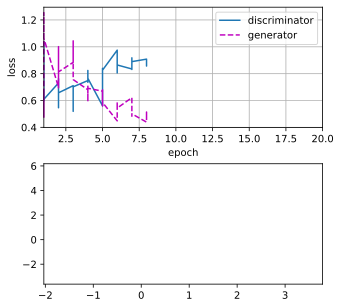

In [15]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
train(net_D,net_G,data_iter,num_epochs,lr_D,lr_G,latent_dim,data[:100].detach().numpy())

In [ ]:
# trained with cpu and laptop almost blewup... pls use GPU...

In [ ]:
# result is some what quite different from the originer textbook...
# why???

# 20.2. Deep Convolutional Generative Adversarial Networks

In [ ]:
# 2